In [1]:
import numpy as np
from scipy.special import iv
import timeit
import viscid 
import imp
from scipy.linalg import eig
import matplotlib.pyplot as plt
import json

In [2]:
#If you edit viscid while the kernel is running, run this to reload the package
imp.reload(viscid)

<module 'viscid' from '/home/zack/Desktop/faraday/viscid.py'>

In [3]:
args=viscid.args

### Dispersion relation for the inviscid problem in Sec. III. The notes Sec. IV describe continuation to the viscid problem starting from the inviscid dispersion, but I haven't been able to do that yet. Instead, below, I continue starting from the instability boundary described in Sec. V, starting with a flat substrate and changing As and ad in turn.

In [4]:
num=50

start=timeit.default_timer()
kxs1=np.arange(1,num+1)/num*args.k1x/2
kys1=np.arange(1,num+1)/num*0

evalssweep1=[]
for i in range(num):
    args.kx=kxs1[i]
    args.ky=kys1[i]
    F,G=viscid.inviscid_mat(args)
    Fflattened=np.transpose(F[0,0],(0,2,1,3)).reshape(((2*args.Nx+1)*(2*args.Ny+1),(2*args.Nx+1)*(2*args.Ny+1)))
    Gflattened=np.transpose(G[0,0],(0,2,1,3)).reshape(((2*args.Nx+1)*(2*args.Ny+1),(2*args.Nx+1)*(2*args.Ny+1)))
    evals,evecs=eig(Fflattened,Gflattened)
    evalssweep1=evalssweep1+[evals]
stop=timeit.default_timer()
print(stop-start)

start=timeit.default_timer()
kxs2=args.k1x/2+np.arange(1,num)/num*((2*args.k1x + args.k2x)/3 - args.k1x/2)
kys2=args.k1y/2+np.arange(1,num)/num*((2*args.k1y + args.k2y)/3 - args.k1y/2)
evalssweep2=[]
for i in range(num-1):
    args.kx=kxs2[i]
    args.ky=kys2[i]
    F,G=viscid.inviscid_mat(args)
    Fflattened=np.transpose(F[0,0],(0,2,1,3)).reshape(((2*args.Nx+1)*(2*args.Ny+1),(2*args.Nx+1)*(2*args.Ny+1)))
    Gflattened=np.transpose(G[0,0],(0,2,1,3)).reshape(((2*args.Nx+1)*(2*args.Ny+1),(2*args.Nx+1)*(2*args.Ny+1)))
    evals,evecs=eig(Fflattened,Gflattened)
    evalssweep2=evalssweep2+[evals]
stop=timeit.default_timer()
print(stop-start)

start=timeit.default_timer()
kxs3=np.arange(1,num)/num*((2*args.k1x + args.k2x)/3)
kys3=np.arange(1,num)/num*((2*args.k1y + args.k2y)/3)
evalssweep3=[]
for i in range(num-1):
    args.kx=kxs3[i]
    args.ky=kys3[i]
    F,G=viscid.inviscid_mat(args)
    Fflattened=np.transpose(F[0,0],(0,2,1,3)).reshape(((2*args.Nx+1)*(2*args.Ny+1),(2*args.Nx+1)*(2*args.Ny+1)))
    Gflattened=np.transpose(G[0,0],(0,2,1,3)).reshape(((2*args.Nx+1)*(2*args.Ny+1),(2*args.Nx+1)*(2*args.Ny+1)))
    evals,evecs=eig(Fflattened,Gflattened)
    evalssweep3=evalssweep3+[evals]
stop=timeit.default_timer()
print(stop-start)

0.7647089000000005
0.7440248369999996
0.731890344


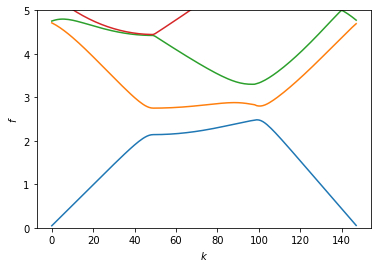

In [5]:
vals1=np.sort(np.abs(np.imag(np.array(evalssweep1)**0.5/(2*np.pi))),axis=1)
vals2=np.sort(np.abs(np.imag(np.array(evalssweep2)**0.5/(2*np.pi))),axis=1)
vals3=np.flip(np.sort(np.abs(np.imag(np.array(evalssweep3)**0.5/(2*np.pi))),axis=1),axis=0)

plt.ylim(0,5)
plt.plot(np.concatenate([vals1,vals2,vals3]))
plt.xlabel('$k$')
plt.ylabel('$f$')           
plt.show()

In [6]:
imp.reload(viscid)

<module 'viscid' from '/Users/zack/Desktop/shaker_docs/faraday/viscid.py'>

0.0500875609996001


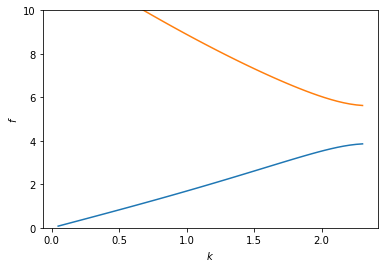

In [37]:
num=50

start=timeit.default_timer()
args.k1x=4.7
args.mu=0.009
args.sigma=72
args.h0=0.15
args.As=0.1
args.dim=1


ks=np.arange(1,num)/num*args.k1x/2
evalssweep1=[]
for k in ks:
    args.kx=k
    F,G=viscid.inviscid_mat(args)
    Fflattened=F[0,0]
    Gflattened=G[0,0]
    evals,evecs=eig(Fflattened,Gflattened)
    evalssweep1=evalssweep1+[evals]
stop=timeit.default_timer()
print(stop-start)
vals1=np.sort(np.abs(np.imag(np.array(evalssweep1)**0.5))/(2*np.pi),axis=1)

plt.ylim(0,10)
plt.plot(ks,vals1)
plt.xlabel('$k$')
plt.ylabel('$f$')           
plt.show()

In [114]:
np.pi*4.2

13.194689145077131

In [401]:
args.dim=1
args.freq=4
args.kx=1.0
args.ky=0
args.ad=0
args.mu=0.005


F,G=viscid.inviscid_mat(args)
Fflattened=F[0,0]
Gflattened=G[0,0]

evals,levecs,revecs=eig(Fflattened,Gflattened,left=True)
order=np.argsort(-evals)
ind=order[0]
omega_inviscid=(-evals[ind])**0.5
print(omega_inviscid)
v0_inviscid=revecs[:,ind]
w0_inviscid=np.conjugate(levecs[:,ind])

v=np.zeros((2,(2*args.Nt+1),(2*args.Nx+1)),dtype=np.complex128)
w=np.zeros((2,(2*args.Nt+1),(2*args.Nx+1)),dtype=np.complex128)
v[1,args.Nt+0]=v0_inviscid
# w[1,args.Nt+0]=w0_inviscid
w[1,args.Nt+0]=1

E=viscid.viscid_mat(omega_inviscid,args)
dE=(viscid.viscid_mat(omega_inviscid+args.domega_fd,args)-E)/args.domega_fd
print(np.einsum("kKmMnN,kmn,KMN",E,w,v)/np.einsum("kKmMnN,kmn,KMN",dE,w,v))
print(np.einsum("mM,m,M",F[0,0]-evals[ind]*G[0,0],w0_inviscid,v0_inviscid)/np.einsum("mM,m,M",G[0,0],w0_inviscid,v0_inviscid))
print(np.linalg.norm(np.einsum("mM,m",F[0,0]-evals[ind]*G[0,0],w0_inviscid)))
print(np.linalg.norm(np.einsum("mM,M",F[0,0]-evals[ind]*G[0,0],v0_inviscid)))


(9.179976611672592+0j)
(0.013591717790917949-0.16287736206496364j)
(4.106691338758122e-12+0j)
1.2703799002623326e-10
1.2237372885450877e-10


In [402]:
imp.reload(viscid)
omegas,vs,ws=viscid.rayleigh(omega_inviscid,v,w,args)
omegas

[(9.166384893881673+0.16287736206496364j),
 (8.43326499897864+1.6118239638516068j),
 (8.310064597895863+1.4970394694183333j),
 (8.315817947006346+1.5096766347508148j),
 (8.315779644593933+1.50962225966412j),
 (8.3157798143288+1.5096225443953293j),
 (8.315779813591043+1.5096225429154404j),
 (8.315779813594157+1.509622542923086j),
 (8.315779813594144+1.509622542923038j),
 (8.315779813594142+1.509622542923044j),
 (8.31577981359414+1.5096225429230405j),
 (8.315779813594142+1.509622542923044j),
 (8.31577981359414+1.5096225429230394j),
 (8.315779813594142+1.5096225429230394j),
 (8.31577981359414+1.5096225429230412j),
 (8.315779813594142+1.5096225429230434j),
 (8.31577981359414+1.5096225429230397j),
 (8.315779813594142+1.5096225429230432j),
 (8.31577981359414+1.509622542923042j),
 (8.31577981359414+1.5096225429230412j)]

In [403]:
E=viscid.viscid_mat(omegas[-1], args)
print(np.linalg.norm(np.einsum("kKlLmM,KLM",E,vs[-1])))
print(np.linalg.norm(np.einsum("kKlLmM,klm",E,ws[-1])))

6.845309617702913e-15
4.3278436116095147e-16


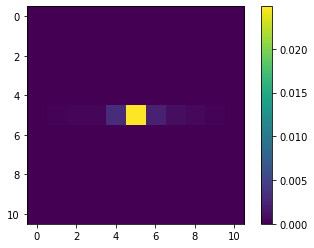

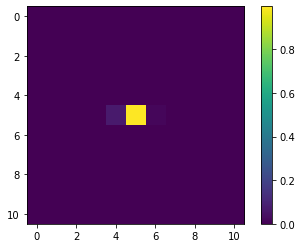

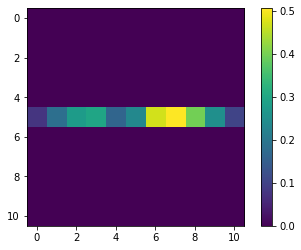

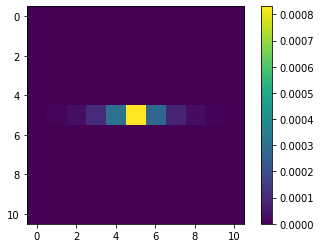

In [404]:
plt.imshow(np.abs(vs[-1][0,:,:]))
plt.colorbar()
plt.show()
plt.imshow(np.abs(vs[-1][1,:,:]))
plt.colorbar()
plt.show()
plt.imshow(np.abs(ws[-1][0,:,:]))
plt.colorbar()
plt.show()
plt.imshow(np.abs(ws[-1][1,:,:]))
plt.colorbar()
plt.show()


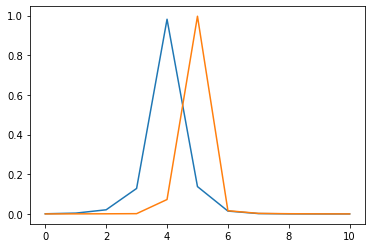

In [405]:
plt.plot(np.abs(levecs[:,order[1]]))
plt.plot(np.abs(vs[-1][1,args.Nt,:]))

### Viscid instability boundary for flat substrate

In [85]:
imp.reload(viscid)

<module 'viscid' from '/Users/zack/Desktop/shaker_docs/faraday/viscid.py'>

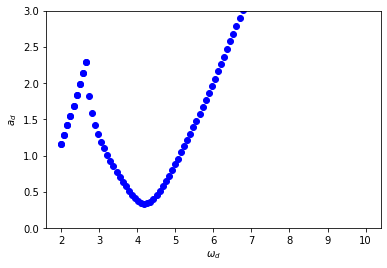

In [322]:
evalssweep=[]
args.kx=1.4

omegas=np.linspace(2*np.pi*2, 2*np.pi*10, 100)
for omega in omegas:
    args.freq=omega/(2*np.pi)
    Ftilde_0,Gtilde_0=viscid.viscid_flat_boundary(omega/2,args)
    Ftildeflattened_0=np.transpose(Ftilde_0,(0,2,1,3)).reshape((2*(2*args.Nt+1),2*(2*args.Nt+1)))
    Gtildeflattened_0=np.transpose(Gtilde_0,(0,2,1,3)).reshape((2*(2*args.Nt+1),2*(2*args.Nt+1)))
    evals,levecs,revecs=eig(Ftildeflattened_0,Gtildeflattened_0,left=True)
    evalssweep=evalssweep+[evals]

plt.plot(omegas/(2*np.pi),np.real(evalssweep)/args.g,'bo')
plt.ylim(0,3)
plt.xlabel(r'$\omega_d$')
plt.ylabel('$a_d$')
plt.show()

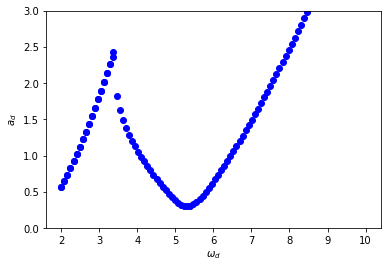

In [218]:
evalssweep=[]
args.kx=args.k1x-1.4

omegas=np.linspace(2*np.pi*2, 2*np.pi*10, 100)
for omega in omegas:
    args.freq=omega/(2*np.pi)
    Ftilde_0,Gtilde_0=viscid.viscid_flat_boundary(omega/2,args)
    Ftildeflattened_0=np.transpose(Ftilde_0,(0,2,1,3)).reshape((2*(2*args.Nt+1),2*(2*args.Nt+1)))
    Gtildeflattened_0=np.transpose(Gtilde_0,(0,2,1,3)).reshape((2*(2*args.Nt+1),2*(2*args.Nt+1)))
    evals,levecs,revecs=eig(Ftildeflattened_0,Gtildeflattened_0,left=True)
    evalssweep=evalssweep+[evals]

plt.plot(omegas/(2*np.pi),np.real(evalssweep)/args.g,'bo')
plt.ylim(0,3)
plt.xlabel(r'$\omega_d$')
plt.ylabel('$a_d$')
plt.show()

In [69]:
imp.reload(viscid)

<module 'viscid' from '/Users/zack/Desktop/shaker_docs/faraday/viscid.py'>

In [323]:
args.kx=1.4
args.freq=4
Ftilde_0,Gtilde_0=viscid.viscid_flat_boundary(np.pi*args.freq,args)
Ftildeflattened_0=np.transpose(Ftilde_0,(0,2,1,3)).reshape((2*(2*args.Nt+1),2*(2*args.Nt+1)))
Gtildeflattened_0=np.transpose(Gtilde_0,(0,2,1,3)).reshape((2*(2*args.Nt+1),2*(2*args.Nt+1)))
evals,levecs,revecs=eig(Ftildeflattened_0,Gtildeflattened_0,left=True)

In [325]:
ind=14
print(evals[ind]/args.g)
v0=revecs[:,ind].reshape((2,(2*args.Nt+1)))
w0=np.conjugate(levecs[:,ind]).reshape((2,(2*args.Nt+1)))

(0.37971773223637717-6.695173918647134e-16j)


In [326]:
e1=np.linalg.norm(np.einsum("kKlL,KL",Ftilde_0,v0)-evals[ind]*np.einsum("kKlL,KL",Gtilde_0,v0))
e2=np.linalg.norm(np.einsum("kKlL,kl",Ftilde_0,w0)-evals[ind]*np.einsum("kKlL,kl",Gtilde_0,w0))
print(e1,e2,(np.einsum("kKlL,KL,kl",Ftilde_0,v0,w0)/np.einsum("kKlL,KL,kl",Gtilde_0,v0,w0)))

3.6536484377498e-14 6.4569137273500225e-15 (372.1233775916487+9.696527396518037e-14j)


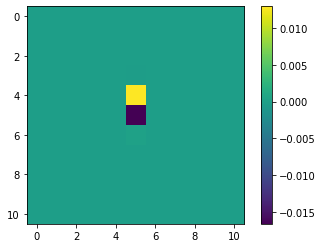

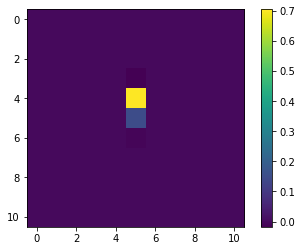

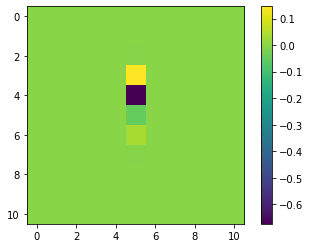

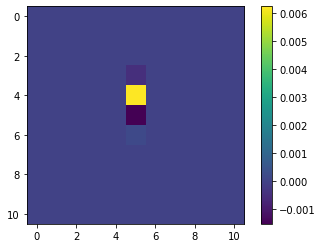

In [327]:
v=np.zeros((2,(2*args.Nt+1),(2*args.Nx+1)),dtype=np.complex128)
w=np.zeros((2,(2*args.Nt+1),(2*args.Nx+1)),dtype=np.complex128)
v[:,:,args.Nx]=v0
w[:,:,args.Nx]=w0

plt.imshow(np.real(v[0]))
plt.colorbar()
plt.show()
plt.imshow(np.real(v[1]))
plt.colorbar()
plt.show()
plt.imshow(np.real(w[0]))
plt.colorbar()
plt.show()
plt.imshow(np.real(w[1]))
plt.colorbar()
plt.show()

In [328]:
args.ad=np.real(evals[ind])
num=25
Ass=np.arange(num+1)/num*0.05
omega=np.pi*args.freq
for As in Ass:
    args.As=As
    omegas,vs,ws=viscid.rayleigh(omega,v,w,args)
    omega=omegas[-1]
    v=vs[-1]
    w=ws[-1]
    print(As,omega)

0.0 (12.566370614359172-3.143875130238379e-15j)
0.002 (12.566370614359172-0.0004548180430064798j)
0.004 (12.56637061435917-0.0017520225712366897j)
0.006 (12.566370614359165-0.0036928170338133715j)
0.008 (12.566370614359151-0.005955178563364729j)
0.010000000000000002 (12.566370614359133-0.008106074111886406j)
0.012 (12.5663706143591-0.009615512902088296j)
0.014000000000000002 (12.566370614359053-0.009870218044916071j)
0.016 (12.566370614358988-0.008184900574725193j)
0.018 (12.5663706143589-0.0038095115920812822j)
0.020000000000000004 (12.566370614358792+0.004068757685096764j)
0.022000000000000002 (12.566370614358679+0.016329725493307662j)
0.024 (12.566370614358558+0.03393177060533189j)
0.026000000000000002 (12.566370614358467+0.05793219701888814j)
0.028000000000000004 (12.566370614358453+0.08951897225220969j)
0.03 (12.566370614358576+0.13005840848933034j)
0.032 (12.566370614358934+0.18116716089515j)
0.034 (12.566370614359698+0.24482447098890572j)
0.036 (12.566370614361107+0.323556780655

In [329]:
num=25
ads=np.flip(np.arange(num+1)/num*np.real(evals[ind]))
for ad in ads:
    args.ad=ad
    omegas,vs,ws=viscid.rayleigh(omega,v,w,args)
    omega=omegas[-1]
    v=vs[-1]
    w=ws[-1]
    print(ad,omega)

372.1233775916496 (13.238255998935799+1.780183699770283j)
357.2384424879836 (13.298400954188946+1.7806697285547424j)
342.35350738431765 (13.351804028917414+1.781131085250717j)
327.46857228065164 (13.39975926165912+1.7815684590485505j)
312.5836371769857 (13.443158176509076+1.781982490021382j)
297.6987020733197 (13.482645768924353+1.7823737722741557j)
282.8137669696537 (13.51870620286962+1.7827428568079817j)
267.9288318659877 (13.55171347288811+1.783090254125998j)
253.04389676232176 (13.581963106787613+1.7834164366040999j)
238.15896165865576 (13.609692926455164+1.7837218406470583j)
223.27402655498977 (13.635097157491064+1.7840068686481874j)
208.3890914513238 (13.658336318789896+1.784271890769061j)
193.5041563476578 (13.679544336196743+1.7845172465530579j)
178.6192212439918 (13.698833772872545+1.7847432463860966j)
163.73428614032582 (13.716299747148465+1.7849501728151644j)
148.84935103665984 (13.73202291366107+1.785138281735029j)
133.96441593299386 (13.746071761524133+1.7853078034516658j)

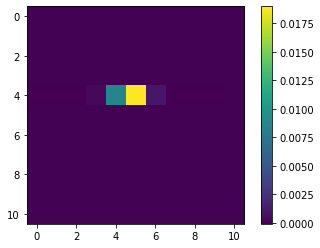

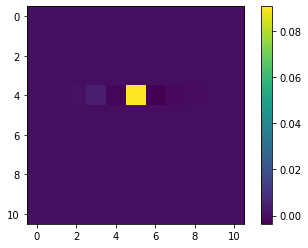

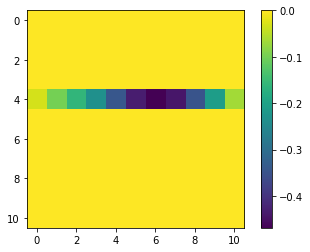

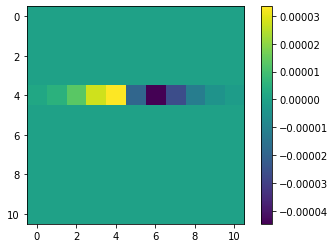

In [243]:
plt.imshow(np.real(v[0]))
plt.colorbar()
plt.show()
plt.imshow(np.real(v[1]))
plt.colorbar()
plt.show()
plt.imshow(np.real(w[0]))
plt.colorbar()
plt.show()
plt.imshow(np.real(w[1]))
plt.colorbar()
plt.show()

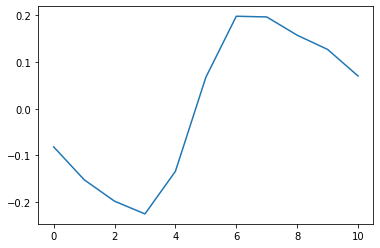

In [211]:
plt.plot(np.real(w[0,args.Nt-1]))

### Continue the flat viscid instability boundary to the sinusoidal viscid instability boundary, As=0 to As=0.05

In [9]:
from scipy.linalg import solve
from scipy.linalg import LinAlgWarning
import warnings
warnings.filterwarnings("error",category=LinAlgWarning)

start=timeit.default_timer()
viscid.args.freq=2*(q*np.tanh(q*args.h0)*(args.g+args.sigma*q**2))**0.5/(2*np.pi)

omega=2*np.pi*viscid.args.freq/2
Ftilde_0,Gtilde_0=viscid.viscid_flat_mat(omega,qx,qy)
Ftildeflattened_0=np.transpose(Ftilde_0,(0,2,1,3)).reshape((3*(2*args.Nt+1),3*(2*args.Nt+1)))
Gtildeflattened_0=np.transpose(Gtilde_0,(0,2,1,3)).reshape((3*(2*args.Nt+1),3*(2*args.Nt+1)))
evals,levecs,revecs=eig(Ftildeflattened_0,Gtildeflattened_0,left=True)
v0=revecs[:,~np.isinf(evals)][:,-1].reshape((3,(2*args.Nt+1)))
w0=np.conjugate(levecs[:,~np.isinf(evals)][:,-1].reshape((3,(2*args.Nt+1))))
e1=np.linalg.norm(np.einsum("kKlL,KL",Ftilde_0,v0)-evals[~np.isinf(evals)][-1]*np.einsum("kKlL,KL",Gtilde_0,v0))
e2=np.linalg.norm(np.einsum("kKlL,kl",Ftilde_0,w0)-evals[~np.isinf(evals)][-1]*np.einsum("kKlL,kl",Gtilde_0,w0))
print(e1,e2,(np.einsum("kKlL,KL,kl",Ftilde_0,v0,w0)/np.einsum("kKlL,KL,kl",Gtilde_0,v0,w0)))

Ftilde,Gtilde=viscid.viscid_mat2(omega,qx,qy)

v=np.zeros((3,(2*args.Nt+1),(2*args.Nx+1),(2*args.Ny+1)),dtype=np.complex128)
w=np.zeros((3,(2*args.Nt+1),(2*args.Nx+1),(2*args.Ny+1)),dtype=np.complex128)
v[:,:,args.Nx,args.Ny]=v0
w[:,:,args.Nx,args.Ny]=w0

for i in range(10):
    lam=(np.einsum("kKlLmMnN,KLMN,klmn",Ftilde,v,w)/np.einsum("kKlLmMnN,KLMN,klmn",Gtilde,v,w))
    flat=np.transpose(lam*Gtilde-Ftilde,(0,2,4,6,1,3,5,7)).reshape((3*(2*args.Nt+1)*(2*args.Nx+1)*(2*args.Ny+1),3*(2*args.Nt+1)*(2*args.Nx+1)*(2*args.Ny+1)))
    try:
        xi=solve(flat, np.einsum("kKlLmMnN,KLMN",Gtilde,v).reshape(3*(2*args.Nt+1)*(2*args.Nx+1)*(2*args.Ny+1))).reshape(3,(2*args.Nt+1),(2*args.Nx+1),(2*args.Ny+1))
        zeta=solve(flat.T, np.einsum("kKlLmMnN,klmn",Gtilde,w).reshape(3*(2*args.Nt+1)*(2*args.Nx+1)*(2*args.Ny+1))).reshape(3,(2*args.Nt+1),(2*args.Nx+1),(2*args.Ny+1))
        v=xi/np.linalg.norm(xi)
        w=zeta/np.linalg.norm(zeta)
    except LinAlgWarning:
        print('convergence')
        lam=(np.einsum("kKlLmMnN,KLMN,klmn",Ftilde,v,w)/np.einsum("kKlLmMnN,KLMN,klmn",Gtilde,v,w))
        e1=np.linalg.norm(np.einsum("kKlLmMnN,KLMN",Ftilde,v)-lam*np.einsum("kKlLmMnN,KLMN",Gtilde,v))
        e2=np.linalg.norm(np.einsum("kKlLmMnN,klmn",Ftilde,w)-lam*np.einsum("kKlLmMnN,klmn",Gtilde,w))
        print(e1,e2,lam,flush=True)
        break

    e1=np.linalg.norm(np.einsum("kKlLmMnN,KLMN",Ftilde,v)-lam*np.einsum("kKlLmMnN,KLMN",Gtilde,v))
    e2=np.linalg.norm(np.einsum("kKlLmMnN,klmn",Ftilde,w)-lam*np.einsum("kKlLmMnN,klmn",Gtilde,w))
    print(e1,e2,lam,flush=True)
stop=timeit.default_timer()
print(stop-start)

4.444532364360808e-14 5.610044483985782e-16 (407.77882050082826-2.065274783480644e-14j)
0.8500876918116247 0.008705073926304017 (407.7788205008283-1.563342137980205e-12j)
0.05652196426419497 0.0007419699138940009 (337.49169841891364+3.389680553544659e-10j)
6.639346753407486e-06 8.758350655118355e-08 (330.37004669745176-2.4192660172893576e-11j)
convergence
6.526256816739376e-09 1.3631939313809846e-10 (330.3692042645837-2.7053169490052313e-11j)
15.962798679


### Continue the instability boundary mode to the undriven mode, ad=330 to ad=0

In [10]:
start=timeit.default_timer()
domega_fd=0.1

viscid.args.ad=np.real(lam)
dad=-np.real(lam)/10

E0=viscid.viscid_mat(omega,qx,qy)
print(np.einsum("kKlLmMnN,KLMN,klmn",E0,v,w))

vn=v
wn=w

itmax=100
omegas=[]
ads=[]
vns=[]
wns=[]
while viscid.args.ad/np.real(lam)>0:
    viscid.args.ad += dad
    for i in range(itmax):
        E_new=viscid.viscid_mat(omega,qx,qy)
        print(omega, np.einsum("kKlLmMnN,KLMN,klmn",E_new,vn,wn))
        dE=(viscid.viscid_mat(omega+domega_fd,qx,qy)-E_new)/domega_fd
        flat=np.transpose(E_new,(0,2,4,6,1,3,5,7)).reshape((3*(2*args.Nt+1)*(2*args.Nx+1)*(2*args.Ny+1),3*(2*args.Nt+1)*(2*args.Nx+1)*(2*args.Ny+1)))
        dflat=np.transpose(dE,(0,2,4,6,1,3,5,7)).reshape((3*(2*args.Nt+1)*(2*args.Nx+1)*(2*args.Ny+1),3*(2*args.Nt+1)*(2*args.Nx+1)*(2*args.Ny+1)))
        try:
            xi=solve(flat, np.einsum("kKlLmMnN,KLMN",dE,vn).reshape(3*(2*args.Nt+1)*(2*args.Nx+1)*(2*args.Ny+1))).reshape(3,(2*args.Nt+1),(2*args.Nx+1),(2*args.Ny+1))
            zeta=solve(flat.T, np.einsum("kKlLmMnN,klmn",dE,wn).reshape(3*(2*args.Nt+1)*(2*args.Nx+1)*(2*args.Ny+1))).reshape(3,(2*args.Nt+1),(2*args.Nx+1),(2*args.Ny+1))
            domega=-np.einsum("kKlLmMnN,KLMN,klmn",E_new,vn,wn)/np.einsum("kKlLmMnN,KLMN,klmn",dE,vn,wn)
            omega=omega+domega
            vn=xi/np.linalg.norm(xi)
            wn=zeta/np.linalg.norm(zeta)
        except LinAlgWarning:
            print('convergence')
            domega=-np.einsum("kKlLmMnN,KLMN,klmn",E_new,vn,wn)/np.einsum("kKlLmMnN,KLMN,klmn",dE,vn,wn)
            omega=omega+domega
            omegas=omegas+[omega]
            ads=ads+[viscid.args.ad]
            vns=vns+[vn]
            wns=wns+[wn]
            print(viscid.args.ad,i,omega, np.einsum("kKlLmMnN,KLMN,klmn",E_new,vn,wn))
            break

stop=timeit.default_timer()
print(stop-start)

(-5.402075050290822e-18-2.3253965669697706e-16j)
15.871765605769195 (0.0002846642277922215-1.4508557545652755e-12j)
(15.871877480119212+0.13324434269642263j) (-2.2947922018868736e-06-2.4428870668828594e-07j)
(15.871767816292024+0.13430312954709042j) (9.86377948562846e-09+2.8305672066908386e-09j)
(15.87176561018604+0.13430732353899957j) (-6.9527604740264535e-12-8.159471785794652e-12j)
convergence
297.3322838381253 3 (15.871765605766985+0.1343073213078293j) (-6.9527604740264535e-12-8.159471785794652e-12j)
(15.871765605766985+0.1343073213078293j) (-0.00011332851330538246+0.00027070143648082445j)
(15.8718997445334+0.2698455042241481j) (1.5496730724171389e-06-2.93528353466037e-06j)
(15.871769145600405+0.27136218127910505j) (-1.1422372601596814e-08+1.5330619324235028e-08j)
(15.871765615804355+0.2713702253964869j) (2.3235063598973465e-11-4.7389404703844665e-12j)
convergence
264.2953634116669 3 (15.87176560576414+0.2713702211635633j) (2.3235063598973465e-11-4.7389404703844665e-12j)
(15.8717656

#### The eigenvalue initially increasese in imaginary component (damping) before colliding with another (undetected, conjugate) mode and then increases in the real component. This is the resonance phenomena with the comlex conjugate mode, leading to the subharmonic response.

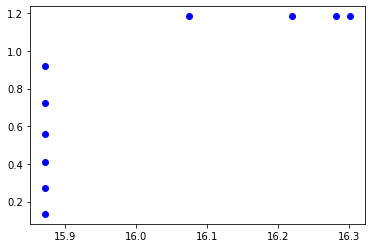

In [11]:
plt.plot(np.real(omegas),np.imag(omegas),'bo')

#### Compare the eigenvectors for the undriven viscid and inviscid solutions. They are similar, up to a complex factor.

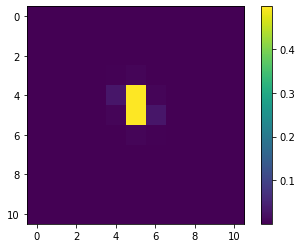

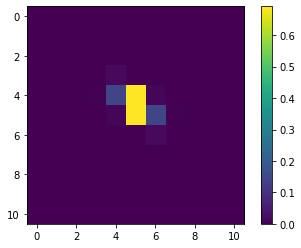

In [12]:
plt.imshow(np.abs(vns[2][2,args.Nt]).T)
plt.colorbar()
plt.show()
plt.imshow(np.abs(v0_inviscid).T)
plt.colorbar()
plt.show()

### Continue inviscid mode to the viscid one instead

In [15]:
imp.reload(viscid)

<module 'viscid' from '/Users/zack/Desktop/shaker_docs/faraday/viscid.py'>

In [14]:
from scipy.linalg import solve
from scipy.linalg import LinAlgWarning
import warnings
warnings.filterwarnings("error",category=LinAlgWarning)

viscid.args.freq=5
viscid.args.ad=0

F,G=viscid.inviscid_mat(args)
Fflattened=np.transpose(F[0,0],(0,2,1,3)).reshape(((2*args.Nx+1)*(2*args.Ny+1),(2*args.Nx+1)*(2*args.Ny+1)))
Gflattened=np.transpose(G[0,0],(0,2,1,3)).reshape(((2*args.Nx+1)*(2*args.Ny+1),(2*args.Nx+1)*(2*args.Ny+1)))
evals,levecs,revecs=eig(Fflattened,Gflattened,left=True)

ind=np.argmin((-evals)**0.5)+1
print(ind,evals[ind])
v0_inviscid=revecs[:,ind].reshape(((2*args.Nx+1),(2*args.Ny+1)))
w0_inviscid=np.conjugate(levecs[:,ind].reshape(((2*args.Nx+1),(2*args.Ny+1))))
omega_inviscid=(-evals[ind])**0.5

args.mu=0.005
E=viscid.viscid_mat(omega_inviscid,args)

v=np.zeros((3,(2*args.Nt+1),(2*args.Nx+1),(2*args.Ny+1)),dtype=np.complex128)
w=np.zeros((3,(2*args.Nt+1),(2*args.Nx+1),(2*args.Ny+1)),dtype=np.complex128)
v[2,args.Nt]=v0_inviscid
w[2,args.Nt]=w0_inviscid
print(omega_inviscid,np.einsum("kKlLmMnN,KLMN,klmn",E,v,w))

0 0.05 0.1 1 20 0.005 980 2
63 (-298.9937927425745+0j)
(17.291436977376243+0j) (-0.049058451351176674-1.7727713506632088j)


In [18]:
start=timeit.default_timer()

domega=1e-1
omega=omega_inviscid
itmax=100
for i in range(itmax):
    E=viscid.viscid_mat(omega,args)
    dE=(viscid.viscid_mat(omega+domega,args)-E)/domega
    omega=omega-np.einsum("kKlLmMnN,KLMN,klmn",E,v,w)/np.einsum("kKlLmMnN,KLMN,klmn",dE,v,w)
    flat=np.transpose(E,(0,2,4,6,1,3,5,7)).reshape((3*(2*args.Nt+1)*(2*args.Nx+1)*(2*args.Ny+1),3*(2*args.Nt+1)*(2*args.Nx+1)*(2*args.Ny+1)))
    try:
        xi=solve(flat, np.einsum("kKlLmMnN,KLMN",dE,v).reshape(3*(2*args.Nt+1)*(2*args.Nx+1)*(2*args.Ny+1))).reshape(3,(2*args.Nt+1),(2*args.Nx+1),(2*args.Ny+1))
        zeta=solve(flat.T, np.einsum("kKlLmMnN,klmn",dE,w).reshape(3*(2*args.Nt+1)*(2*args.Nx+1)*(2*args.Ny+1))).reshape(3,(2*args.Nt+1),(2*args.Nx+1),(2*args.Ny+1))
        v=xi/np.linalg.norm(xi)
        w=zeta/np.linalg.norm(zeta)
    except LinAlgWarning:
        print('convergence')
        omega=omega-np.einsum("kKlLmMnN,KLMN,klmn",E,v,w)/np.einsum("kKlLmMnN,KLMN,klmn",dE,v,w)
        e1=np.linalg.norm(np.einsum("kKlLmMnN,KLMN",E,v))
        e2=np.linalg.norm(np.einsum("kKlLmMnN,klmn",E,w))
        print(e1,e2,omega,flush=True)
        break

    e1=np.linalg.norm(np.einsum("kKlLmMnN,KLMN",E,v))
    e2=np.linalg.norm(np.einsum("kKlLmMnN,klmn",E,w))
    print(e1,e2,omega,flush=True)
stop=timeit.default_timer()
print(stop-start)

4.574682658493487 0.027877988104101872 (16.323792476656177+0.028195211995869274j)
2.8553231426661094 0.020004570045683786 (15.479331930622424+1.2328436780383987j)
0.12383143167113762 0.0008596369874377643 (15.442314004083395+1.183376009675183j)
0.0012197917739877975 8.519926473412771e-06 (15.442583785694245+1.1839177456193342j)
3.539329750954373e-06 2.4722231140968734e-08 (15.442582983770482+1.1839161833044662j)
convergence
1.1385720400898464e-08 2.040963932569154e-10 (15.44258298846363+1.1839161924720165j)
32.260735679999925


### Plot Floquet exponent sweeps

In [138]:
filebase='data/test_99'
argsdict=json.load(open(filebase+'argsdict.json'))

plt.subplots(1,3,figsize=(15,5))

plt.subplot(1,3,1)
for imode in range(argsdict['nmodes']):
    evals=np.load(filebase+'evals_cont'+str(imode)+'.npy')
    plt.scatter(np.mod(np.real(evals),(argsdict['freq']*2*np.pi))/(argsdict['freq']*2*np.pi),np.imag(evals))
    if argsdict['negatives']:
        evals=np.load(filebase+'evals_cont'+str(imode+argsdict['nmodes'])+'.npy')
        plt.scatter(np.mod(np.real(evals),(argsdict['freq']*2*np.pi))/(argsdict['freq']*2*np.pi),np.imag(evals))
    else:
        plt.scatter(np.mod(-np.real(evals),(argsdict['freq']*2*np.pi))/(argsdict['freq']*2*np.pi),np.imag(evals))
plt.xlim(0,1)
plt.xlabel('$Re(\omega)/\omega_d$')
plt.ylabel('$Im(\omega)$')

plt.subplot(1,3,2)
for imode in range(argsdict['nmodes']):
    evals=np.load(filebase+'evals_cont'+str(imode)+'.npy')
    plt.plot(argsdict['dad']*np.arange(argsdict['num']+1)/argsdict['num'],np.mod(np.real(evals),(argsdict['freq']*2*np.pi))/(argsdict['freq']*2*np.pi))
    if argsdict['negatives']:
        evals=np.load(filebase+'evals_cont'+str(imode+argsdict['nmodes'])+'.npy')
        plt.plot(argsdict['dad']*np.arange(argsdict['num']+1)/argsdict['num'],np.mod(np.real(evals),(argsdict['freq']*2*np.pi))/(argsdict['freq']*2*np.pi))
    else:
        plt.plot(argsdict['dad']*np.arange(argsdict['num']+1)/argsdict['num'],np.mod(-np.real(evals),(argsdict['freq']*2*np.pi))/(argsdict['freq']*2*np.pi))
plt.xlabel('$a_d$')
plt.ylabel('$Re(\omega)$')

plt.subplot(1,3,3)
for imode in range(argsdict['nmodes']):
    evals=np.load(filebase+'evals_cont'+str(imode)+'.npy')
    plt.plot(argsdict['dad']*np.arange(argsdict['num']+1)/argsdict['num'],np.imag(evals))
    if argsdict['negatives']:
        evals=np.load(filebase+'evals_cont'+str(imode+argsdict['nmodes'])+'.npy')
        plt.plot(argsdict['dad']*np.arange(argsdict['num']+1)/argsdict['num'],np.imag(evals))
    else:
        plt.plot(argsdict['dad']*np.arange(argsdict['num']+1)/argsdict['num'],np.imag(evals))
plt.xlabel('$a_d$')
plt.ylabel('$Im(\omega)$')
plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'data/test_99argsdict.json'

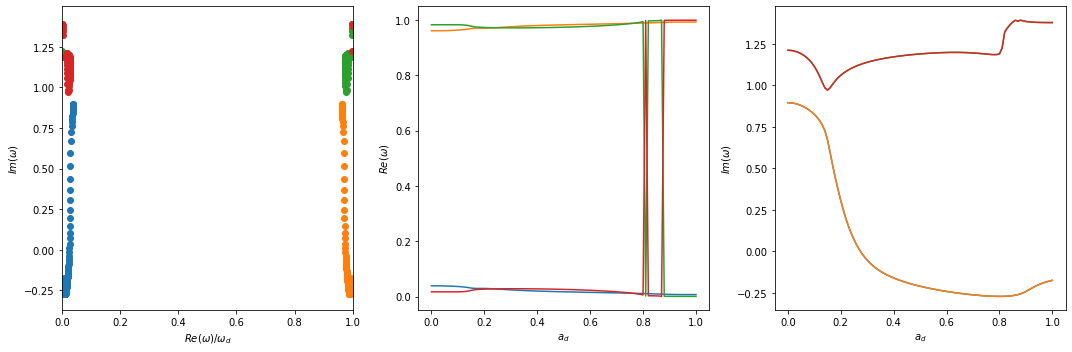

In [98]:
filebase='data/test2'
argsdict=json.load(open(filebase+'args.json'))

plt.subplots(1,3,figsize=(15,5))

plt.subplot(1,3,1)
for imode in range(argsdict['nmodes']):
    evals=np.load(filebase+'evals_cont'+str(imode)+'.npy')
    plt.scatter(np.mod(np.real(evals),(argsdict['freq']*2*np.pi))/(argsdict['freq']*2*np.pi),np.imag(evals))
    if argsdict['negatives']:
        evals=np.load(filebase+'evals_cont'+str(imode+argsdict['nmodes'])+'.npy')
        plt.scatter(np.mod(np.real(evals),(argsdict['freq']*2*np.pi))/(argsdict['freq']*2*np.pi),np.imag(evals))
    else:
        plt.scatter(np.mod(-np.real(evals),(argsdict['freq']*2*np.pi))/(argsdict['freq']*2*np.pi),np.imag(evals))
plt.xlim(0,1)
plt.xlabel('$Re(\omega)/\omega_d$')
plt.ylabel('$Im(\omega)$')

plt.subplot(1,3,2)
for imode in range(argsdict['nmodes']):
    evals=np.load(filebase+'evals_cont'+str(imode)+'.npy')
    plt.plot(argsdict['dad']*np.arange(argsdict['num']+1)/argsdict['num'],np.mod(np.real(evals),(argsdict['freq']*2*np.pi))/(argsdict['freq']*2*np.pi))
    if argsdict['negatives']:
        evals=np.load(filebase+'evals_cont'+str(imode+argsdict['nmodes'])+'.npy')
        plt.plot(argsdict['dad']*np.arange(argsdict['num']+1)/argsdict['num'],np.mod(np.real(evals),(argsdict['freq']*2*np.pi))/(argsdict['freq']*2*np.pi))
    else:
        plt.plot(argsdict['dad']*np.arange(argsdict['num']+1)/argsdict['num'],np.mod(-np.real(evals),(argsdict['freq']*2*np.pi))/(argsdict['freq']*2*np.pi))
plt.xlabel('$a_d$')
plt.ylabel('$Re(\omega)$')

plt.subplot(1,3,3)
for imode in range(argsdict['nmodes']):
    evals=np.load(filebase+'evals_cont'+str(imode)+'.npy')
    plt.plot(argsdict['dad']*np.arange(argsdict['num']+1)/argsdict['num'],np.imag(evals))
    if argsdict['negatives']:
        evals=np.load(filebase+'evals_cont'+str(imode+argsdict['nmodes'])+'.npy')
        plt.plot(argsdict['dad']*np.arange(argsdict['num']+1)/argsdict['num'],np.imag(evals))
    else:
        plt.plot(argsdict['dad']*np.arange(argsdict['num']+1)/argsdict['num'],np.imag(evals))
plt.xlabel('$a_d$')
plt.ylabel('$Im(\omega)$')
plt.tight_layout()
plt.show()

In [96]:
for j in range(1,101):
    print("%03d"%(j)+'evals.pdf')
    filebase='data/test_'+str(j)
    argsdict=json.load(open(filebase+'args.json'))

    plt.subplots(1,3,figsize=(15,5))

    plt.subplot(1,3,1)
    for imode in range(argsdict['nmodes']):
        evals=np.load(filebase+'evals_cont'+str(imode)+'.npy')
        plt.scatter(np.mod(np.real(evals),(argsdict['freq']*2*np.pi))/(argsdict['freq']*2*np.pi),np.imag(evals))
        if argsdict['negatives']:
            evals=np.load(filebase+'evals_cont'+str(imode+argsdict['nmodes'])+'.npy')
            plt.scatter(np.mod(np.real(evals),(argsdict['freq']*2*np.pi))/(argsdict['freq']*2*np.pi),np.imag(evals))
        else:
            plt.scatter(np.mod(-np.real(evals),(argsdict['freq']*2*np.pi))/(argsdict['freq']*2*np.pi),np.imag(evals))
    plt.xlim(0,1)
    plt.xlabel('$Re(\omega)/\omega_d$')
    plt.ylabel('$Im(\omega)$')

    plt.subplot(1,3,2)
    for imode in range(argsdict['nmodes']):
        evals=np.load(filebase+'evals_cont'+str(imode)+'.npy')
        plt.plot(argsdict['dad']*np.arange(argsdict['num']+1)/argsdict['num'],np.mod(np.real(evals),(argsdict['freq']*2*np.pi))/(argsdict['freq']*2*np.pi))
        if argsdict['negatives']:
            evals=np.load(filebase+'evals_cont'+str(imode+argsdict['nmodes'])+'.npy')
            plt.plot(argsdict['dad']*np.arange(argsdict['num']+1)/argsdict['num'],np.mod(np.real(evals),(argsdict['freq']*2*np.pi))/(argsdict['freq']*2*np.pi))
        else:
            plt.plot(argsdict['dad']*np.arange(argsdict['num']+1)/argsdict['num'],np.mod(-np.real(evals),(argsdict['freq']*2*np.pi))/(argsdict['freq']*2*np.pi))
    plt.xlabel('$a_d$')
    plt.ylabel('$Re(\omega)$')

    plt.subplot(1,3,3)
    for imode in range(argsdict['nmodes']):
        evals=np.load(filebase+'evals_cont'+str(imode)+'.npy')
        plt.plot(argsdict['dad']*np.arange(argsdict['num']+1)/argsdict['num'],np.imag(evals))
        if argsdict['negatives']:
            evals=np.load(filebase+'evals_cont'+str(imode+argsdict['nmodes'])+'.npy')
            plt.plot(argsdict['dad']*np.arange(argsdict['num']+1)/argsdict['num'],np.imag(evals))
        else:
            plt.plot(argsdict['dad']*np.arange(argsdict['num']+1)/argsdict['num'],np.imag(evals))
    plt.xlabel('$a_d$')
    plt.ylabel('$Im(\omega)$')
    plt.savefig("%03d"%(j)+'evals.pdf')
    plt.close()

{'filebase': 'data/test2',
 'freq': 4.4,
 'ad': 0.0,
 'dad': 1.0,
 'mu': 0.001,
 'rho': 1.0,
 'g': 980,
 'sigma': 20,
 'kx': 0.1,
 'ky': 0,
 'h0': 0.1,
 'As': 0.07,
 'k1x': 3.141592653589793,
 'k1y': 0,
 'k2x': -1.5707963267948966,
 'k2y': 2.7206990463513265,
 'Nt': 5,
 'Nx': 5,
 'Ny': 5,
 'dim': 1,
 'nmodes': 2,
 'itmax': 20,
 'num': 100,
 'domega_fd': 0.1,
 'negatives': 0}

In [131]:
j=25
omega1=np.load('data/test_99evals_cont1.npy')[j]
omega2=np.load('data/test_100evals_cont1.npy')[j]
v1,w1=np.load('data/test_99evecs_cont1.npy')[:,j]
v2,w2=np.load('data/test_100evecs_cont1.npy')[:,j]
print(omega1,omega2)
argsdict=json.load(open('data/test_100'+'args.json'))
ad0=j*argsdict['dad']/100*argsdict['g']
argsdict['ad']=ad0
argsdict['itmax']=30
omegas1,vs1,ws1=viscid.rayleigh(omega1,v1,w1,argsdict)
omegas2,vs2,ws2=viscid.rayleigh(omega2,v2,w2,argsdict)

(15.558269770326863+2.1826967991506994j) (15.65840852149326+2.0030941560183746j)
29 (15.602426849637094+2.2137661555783463j) (-2.2832787997187318e-07+1.9392144049812717e-06j)
29 (15.65842678078603+2.003109749637925j) (1.3027721759616602e-05-1.8246055354124713e-06j)


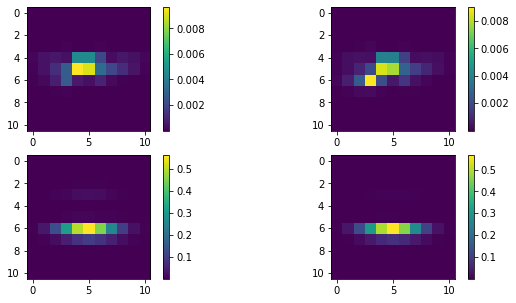

In [132]:
plt.subplots(2,2,figsize=(10,5))
plt.subplot(2,2,1)
plt.imshow(np.abs(vs1[-1][0]))
plt.colorbar()
plt.subplot(2,2,2)
plt.imshow(np.abs(vs2[-1][0]))
plt.colorbar()
plt.subplot(2,2,3)
plt.imshow(np.abs(ws1[-1][0]))
plt.colorbar()
plt.subplot(2,2,4)
plt.imshow(np.abs(ws2[-1][0]))
plt.colorbar()
plt.show()

In [133]:
num=20

omegan=[omegas1[-1]]
vn=[vs1[-1]]
wn=[ws1[-1]]
omegans1=[omegan[-1]]
vns1=[vn[-1]]
wns1=[wn[-1]]

argsdict['ad']=ad0
for it in range(num):
    argsdict['ad'] -= ad0/num
    print(argsdict['ad'])
    omegan,vn,wn=viscid.rayleigh(omegan[-1],vn[-1],wn[-1],argsdict)
    omegans1=omegans1+[omegan[-1]]
    vns1=vns1+[vn[-1]]
    wns1=wns1+[wn[-1]]
    
omegan=[omegas2[-1]]
vn=[vs2[-1]]
wn=[ws2[-1]]
omegans2=[omegan[-1]]
vns2=[vn[-1]]
wns2=[wn[-1]]

argsdict['ad']=ad0
for it in range(num):
    argsdict['ad'] -= ad0/num
    print(argsdict['ad'])
    omegan,vn,wn=viscid.rayleigh(omegan[-1],vn[-1],wn[-1],argsdict)
    omegans2=omegans2+[omegan[-1]]
    vns2=vns2+[vn[-1]]
    wns2=wns2+[wn[-1]]

232.75
29 (15.615845196515728+2.1761692108177315j) (5.801661890134188e-06-7.690473018521517e-07j)
220.5
29 (15.632229288618012+2.1410482632156915j) (1.284426960507587e-06+7.02533656463465e-06j)
208.25
29 (15.651236595989307+2.108372559880197j) (8.952711023077287e-06+9.957468547785595e-06j)
196.0
29 (15.674021633832954+2.0776912956753937j) (8.119871957274223e-06-1.755409345978595e-05j)
183.75
29 (15.705136525727+2.0552763088480246j) (-2.1728063793767714e-06+4.040957341689166e-05j)
171.5
29 (15.729251577582765+2.046321349239005j) (3.8457983822957194e-07-1.1523720031432054e-05j)
159.25
29 (15.746098045629353+2.0387907568870745j) (1.5835424326178327e-05+2.2911786985673234e-06j)
147.0
29 (15.75908315992011+2.0314360973511554j) (3.319048346088384e-07+6.401295820754919e-06j)
134.75
29 (15.769454369146729+2.0242268591599033j) (1.9491186575628272e-05-1.204914516205951e-05j)
122.5
29 (15.777890663546694+2.0171135924824624j) (-6.521536695194204e-06+3.495040941920054e-06j)
110.25
29 (15.7847133335

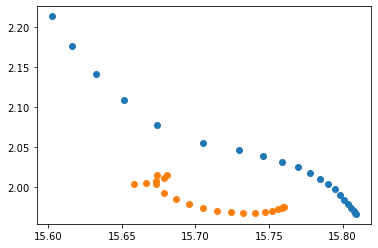

In [134]:
plt.scatter(np.real(omegans1),np.imag(omegans1))
plt.scatter(np.real(omegans2),np.imag(omegans2))

In [137]:
print(omegans1[-1],omegans2[-1])

(15.809123451973047+1.965986396721906j) (15.760174404862378+1.974887434747493j)


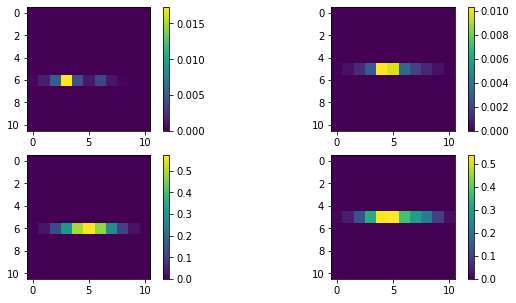

In [135]:
plt.subplots(2,2,figsize=(10,5))
plt.subplot(2,2,1)
plt.imshow(np.abs(vns1[-1][0]))
plt.colorbar()
plt.subplot(2,2,2)
plt.imshow(np.abs(vns2[-1][0]))
plt.colorbar()
plt.subplot(2,2,3)
plt.imshow(np.abs(wns1[-1][0]))
plt.colorbar()
plt.subplot(2,2,4)
plt.imshow(np.abs(wns2[-1][0]))
plt.colorbar()
plt.show()

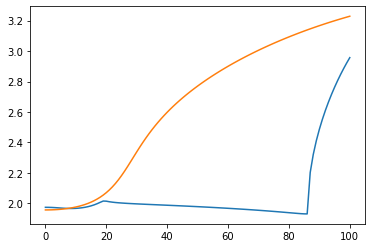

In [76]:
plt.plot(np.imag(np.load('data/test_100evals_cont1.npy')))
plt.plot(np.imag(np.load('data/test_99evals_cont1.npy')))